In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

We start by reading in our dataset

In [2]:
df_raw = pd.read_csv("tmdb_movies_data.csv")
df_raw.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/2015,5562,6.5,2015,137999939.3,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/2015,6185,7.1,2015,137999939.3,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/2015,2480,6.3,2015,101199955.5,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/2015,5292,7.5,2015,183999919.0,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/2015,2947,7.3,2015,174799923.1,1.385749e+09


## Data Preprocessing

Before doing any analysis, I manually inspected different aspects of the data.

We start by checking the types of the attributes

In [3]:
df_raw.dtypes

id                        int64
imdb_id                  object
popularity              float64
budget                    int64
revenue                   int64
original_title           object
cast                     object
homepage                 object
director                 object
tagline                  object
keywords                 object
overview                 object
runtime                   int64
genres                   object
production_companies     object
release_date             object
vote_count                int64
vote_average            float64
release_year              int64
budget_adj              float64
revenue_adj             float64
dtype: object

From here, we can easily eliminate those features which won't be helpful. Items like original_title and id will be too unique to be useful. I'll still include original_title though for my own interest during cleaning

Attributes like vote_average and release_year are numeric values, and good to use as they are.

Director is an nominal value. It would be fine to include as-is, but since it will likely be sparse, I plan to leave it out.

Attributes like genres, keywords, and cast may be useful, but will require extra attention to manipulate them.

Overview and tagline would likely be incredibly useful, but require more effort than what fits the scope of this course.

In [4]:
df_mid = df_raw[["original_title", "popularity", "budget", "revenue", "runtime", "vote_average", "release_year", "keywords", "genres"]].copy()
# at this point, we'll also drop any null values
df_mid = df_mid.dropna()
len(df_mid)

9368

### Checking the Distributions

I first want to check the distributions of the numeric data values to make sure they are reasonable values. I'll do this with a simple boxplot.

In [5]:
attributes = ["popularity", "budget", "revenue", "runtime", "vote_average", "release_year"]

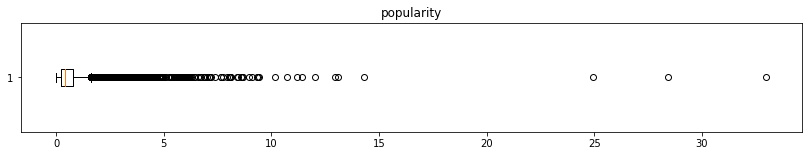

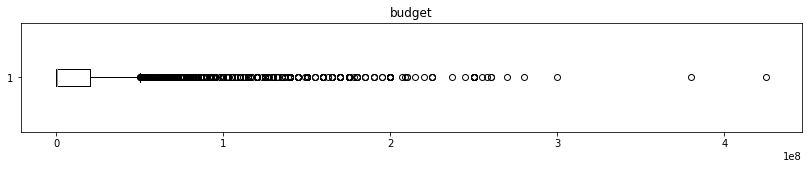

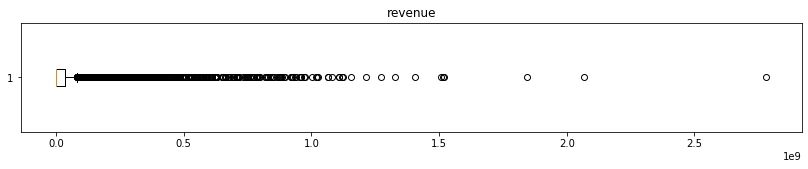

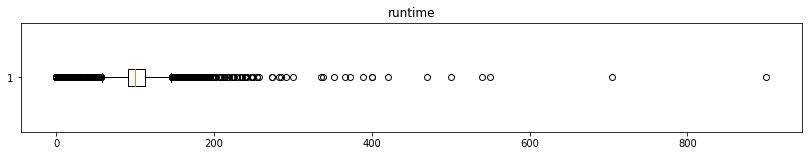

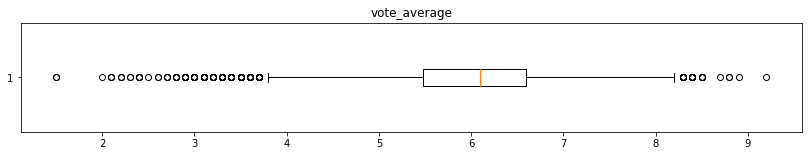

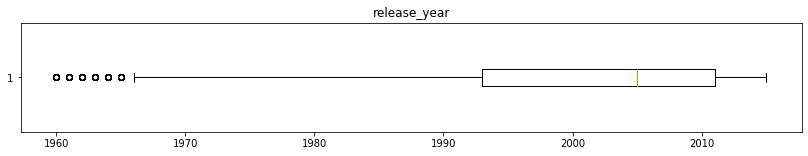

In [6]:
for attr in attributes:
    plt.figure(figsize=(14, 2))
    plt.title(attr)
    plt.boxplot(df_mid[attr], vert=False)

#### Budget/Revenue

As we can see from this, both revenue and budget are highly skewed. This is due to two factors:

1. High number of zeros. There are a large number of 0-valued movie budgets and revenues, which should be removed as nulls

In [7]:
zeros = ((df_mid["budget"] == 0) | (df_mid["revenue"] == 0))
df_mid = df_mid[~zeros]
len(df_mid)

3717

2. Difference in representation. Some of these values represent millions, and some are the actual millions (ie, our data-set can and does have either a 1 or a 1,000,000 to represent the same values)

Since we only need a binary value for our tree, we can partially ignore this issue. The budget and revenue hopefully have the same units, so we can just compare the two. However, there are of course some exceptions. However, it will be incredibly difficult to distinguish from those extremely high performing movies and those data entry errors.

In [8]:
# get a copy of the non-zero entries
df2 = df_raw[~(df_raw["budget"] == 0) & ~(df_raw["revenue"] == 0)].copy()
# take the log of the budget and revenue (to get rough magnitude)
df2["log_budget"] = np.log10(df2["budget"])
df2["log_revenue"] = np.log10(df2["revenue"])
# find the difference in magnitudes
df2["diff"] = np.abs(df2["log_revenue"] - df2["log_budget"])
# find those with a difference greater than 3 (1 thousand off)
df2cut = df2[df2["diff"] > 3]
print(len(df2cut))
df2cut.head()
# can delete these right away, just wasting space
del df2
del df2cut

26


As we can see, a movie like "The Blair Witch Project" is correctly off by this much. Their budget was around 35,000 range and their revenue around 250,000,000 range, so they did make about 4 orders of magnitude more than they spent.

But, "Dr. Horrible's Sing-Along Blog" did have a budget of 200,000, but got a revenue of 3 *million*, not just 3.

Both of these are around a difference of 4 orders of magnitude, but for completely different reasons. Because of this, I'm unfortunately going to remove these values, even though this is certainly cutting out many of the highest performing movies.

In [9]:
df_mid = df_mid[np.abs(np.log10(df_mid["revenue"]) - np.log10(df_mid["budget"])) < 4]

Other than that, success will be based on profit. Most movies had a positive profit, so I made it a little stricter and required them to have a profit of 200%, to make the movie worthwhile

In [10]:
df_mid["profitable"] = df_mid["revenue"] / df_mid["budget"] > 2
print("Number profitable:", len(df_mid[df_mid["profitable"]]), "of", len(df_mid))
df_mid.head()

Number profitable: 1968 of 3701


,original_title,popularity,budget,revenue,runtime,vote_average,release_year,keywords,genres,profitable
0,Jurassic World,32.985763,150000000,1513528810,124,6.5,2015,monster|dna|tyrannosaurus rex|velociraptor|island,Action|Adventure|Science Fiction|Thriller,True
1,Mad Max: Fury Road,28.419936,150000000,378436354,120,7.1,2015,future|chase|post-apocalyptic|dystopia|australia,Action|Adventure|Science Fiction|Thriller,True
2,Insurgent,13.112507,110000000,295238201,119,6.3,2015,based on novel|revolution|dystopia|sequel|dyst...,Adventure|Science Fiction|Thriller,True
3,Star Wars: The Force Awakens,11.173104,200000000,2068178225,136,7.5,2015,android|spaceship|jedi|space opera|3d,Action|Adventure|Science Fiction|Fantasy,True
4,Furious 7,9.335014,190000000,1506249360,137,7.3,2015,car race|speed|revenge|suspense|car,Action|Crime|Thriller,True


#### Popularity

For popularity, I was curious which movies skewed the distribution so much

In [11]:
df_raw[["original_title", "popularity"]].sort_values(by="popularity", ascending=False).head(10)

,original_title,popularity
0,Jurassic World,32.985763
1,Mad Max: Fury Road,28.419936
629,Interstellar,24.949134
630,Guardians of the Galaxy,14.311205
2,Insurgent,13.112507
631,Captain America: The Winter Soldier,12.971027
1329,Star Wars,12.037933
632,John Wick,11.422751
3,Star Wars: The Force Awakens,11.173104
633,The Hunger Games: Mockingjay - Part 1,10.739009


Luckily, just like for budget/revenue, since we are using Decision Tree Induction, this skew doesn't matter. Our model requires a Binary value, so we can just split the popularity at whatever metric we deem best. I chose the top 15% of movies to be "popular", as movies on this boundary were a mix of recognizable and unknown (to me personally)

In [12]:
popularity_cutoff = df_mid["popularity"].quantile(.85)
df_mid["is_popular"] = df_mid["popularity"] > popularity_cutoff
popularity_cutoff

1.956406

For an example of movies on the low end of popular:

In [13]:
df_mid[(df_mid["popularity"] > popularity_cutoff) & (df_mid["popularity"] < popularity_cutoff + .05)]["original_title"].head(15)

85                                Vacation
86                             Poltergeist
87                                  Maggie
704                               The Drop
1405           The Twilight Saga: New Moon
2892    Journey to the Center of the Earth
2893                                Wanted
3401                          Sucker Punch
4389                                  Argo
4390                      American Reunion
4391                            Magic Mike
5459                           Warm Bodies
6570                      Superman Returns
8077                              Bad Boys
8977                          A Bug's Life
Name: original_title, dtype: object

### Getting the keywords and genres

To get the keywords and genres, I need to split the strings representing the list, then form it into a new column.

In [14]:
df_raw["keywords"].head(10)

0    monster|dna|tyrannosaurus rex|velociraptor|island
1     future|chase|post-apocalyptic|dystopia|australia
2    based on novel|revolution|dystopia|sequel|dyst...
3                android|spaceship|jedi|space opera|3d
4                  car race|speed|revenge|suspense|car
5    father-son relationship|rape|based on novel|mo...
6    saving the world|artificial intelligence|cybor...
7          based on novel|mars|nasa|isolation|botanist
8    assistant|aftercreditsstinger|duringcreditssti...
9         dream|cartoon|imaginary friend|animation|kid
Name: keywords, dtype: object

In [15]:
df_raw["genres"].head(10)

0    Action|Adventure|Science Fiction|Thriller
1    Action|Adventure|Science Fiction|Thriller
2           Adventure|Science Fiction|Thriller
3     Action|Adventure|Science Fiction|Fantasy
4                        Action|Crime|Thriller
5             Western|Drama|Adventure|Thriller
6    Science Fiction|Action|Thriller|Adventure
7              Drama|Adventure|Science Fiction
8            Family|Animation|Adventure|Comedy
9                      Comedy|Animation|Family
Name: genres, dtype: object

In [16]:
keywords = Counter()
# go through each row
for line in df_mid["keywords"]:
    # split it into words at the | symbol
    for word in line.split('|'):
        keywords[word] += 1
# sort them by the count
keywords_sorted = sorted(keywords, key=keywords.get, reverse=True)
# re-zip them with the count
keywords = {word: keywords[word] for word in keywords_sorted}
print("There are", len(keywords), "keywords")
keywords

There are 4812 keywords


{'based on novel': 168,
 'duringcreditsstinger': 101,
 'dystopia': 96,
 'sex': 89,
 'independent film': 86,
 'new york': 85,
 'sport': 75,
 'prison': 75,
 'murder': 70,
 'woman director': 69,
 'biography': 64,
 'london': 61,
 'female nudity': 59,
 'musical': 54,
 'sequel': 53,
 'father-son relationship': 50,
 'aftercreditsstinger': 49,
 'corruption': 49,
 'nudity': 48,
 'revenge': 45,
 'brother brother relationship': 45,
 'suspense': 44,
 'high school': 44,
 'suicide': 44,
 'world war ii': 43,
 'martial arts': 43,
 'cia': 41,
 'journalist': 41,
 'police': 41,
 'friendship': 40,
 'detective': 40,
 'paris': 39,
 'prostitute': 38,
 'alcohol': 37,
 'monster': 36,
 'rape': 36,
 'assassin': 36,
 'alien': 35,
 'fight': 35,
 'saving the world': 34,
 'witch': 34,
 'gay': 34,
 'fbi': 34,
 'serial killer': 34,
 "love of one's life": 34,
 'spy': 33,
 'robbery': 33,
 'secret': 33,
 'holiday': 33,
 'helicopter': 32,
 'wife husband relationship': 32,
 'dream': 31,
 'california': 31,
 'undercover': 31

In [17]:
genres = Counter()
for line in df_mid["genres"]:
    for word in line.split('|'):
        genres[word] += 1
genres_sorted = sorted(genres, key=genres.get, reverse=True)
genres = {word: genres[word] for word in genres_sorted}
print("There are", len(genres), "genres")
genres

There are 20 genres


{'Drama': 1684,
 'Comedy': 1292,
 'Thriller': 1162,
 'Action': 1048,
 'Adventure': 725,
 'Crime': 630,
 'Romance': 629,
 'Science Fiction': 510,
 'Horror': 444,
 'Family': 404,
 'Fantasy': 384,
 'Mystery': 336,
 'Animation': 195,
 'Music': 129,
 'History': 126,
 'War': 116,
 'Western': 51,
 'Documentary': 34,
 'Foreign': 10,
 'TV Movie': 1}

Since there are so many keywords, I will only take the top 20 of them. Since there are only 20 genres, I will keep all of them. This will hopefully keep our columns from becoming too sparse.

I will turn each of these 40 values into a new Binary/Boolean column.

In [18]:
keyword_names = []
genre_names = []
for keyword in keywords_sorted[:20]:
    curr_keyword = "keyword_" + keyword.replace(" ", "_")
    keyword_names.append(curr_keyword)
    df_mid[curr_keyword] = df_mid["keywords"].str.contains(keyword)
    
for genre in genres_sorted:
    curr_genre = "genre_" + genre.replace(" ", "_")
    genre_names.append(curr_genre)
    df_mid[curr_genre] = df_mid["genres"].str.contains(genre)

print(keyword_names, "\n")
print(genre_names)
df_mid.head()

['keyword_based_on_novel', 'keyword_duringcreditsstinger', 'keyword_dystopia', 'keyword_sex', 'keyword_independent_film', 'keyword_new_york', 'keyword_sport', 'keyword_prison', 'keyword_murder', 'keyword_woman_director', 'keyword_biography', 'keyword_london', 'keyword_female_nudity', 'keyword_musical', 'keyword_sequel', 'keyword_father-son_relationship', 'keyword_aftercreditsstinger', 'keyword_corruption', 'keyword_nudity', 'keyword_revenge'] 

['genre_Drama', 'genre_Comedy', 'genre_Thriller', 'genre_Action', 'genre_Adventure', 'genre_Crime', 'genre_Romance', 'genre_Science_Fiction', 'genre_Horror', 'genre_Family', 'genre_Fantasy', 'genre_Mystery', 'genre_Animation', 'genre_Music', 'genre_History', 'genre_War', 'genre_Western', 'genre_Documentary', 'genre_Foreign', 'genre_TV_Movie']


,original_title,popularity,budget,revenue,runtime,vote_average,release_year,keywords,genres,profitable,...,genre_Fantasy,genre_Mystery,genre_Animation,genre_Music,genre_History,genre_War,genre_Western,genre_Documentary,genre_Foreign,genre_TV_Movie
0,Jurassic World,32.985763,150000000,1513528810,124,6.5,2015,monster|dna|tyrannosaurus rex|velociraptor|island,Action|Adventure|Science Fiction|Thriller,True,...,False,False,False,False,False,False,False,False,False,False
1,Mad Max: Fury Road,28.419936,150000000,378436354,120,7.1,2015,future|chase|post-apocalyptic|dystopia|australia,Action|Adventure|Science Fiction|Thriller,True,...,False,False,False,False,False,False,False,False,False,False
2,Insurgent,13.112507,110000000,295238201,119,6.3,2015,based on novel|revolution|dystopia|sequel|dyst...,Adventure|Science Fiction|Thriller,True,...,False,False,False,False,False,False,False,False,False,False
3,Star Wars: The Force Awakens,11.173104,200000000,2068178225,136,7.5,2015,android|spaceship|jedi|space opera|3d,Action|Adventure|Science Fiction|Fantasy,True,...,True,False,False,False,False,False,False,False,False,False
4,Furious 7,9.335014,190000000,1506249360,137,7.3,2015,car race|speed|revenge|suspense|car,Action|Crime|Thriller,True,...,False,False,False,False,False,False,False,False,False,False


In [19]:
df_mid.dtypes

original_title                      object
popularity                         float64
budget                               int64
revenue                              int64
runtime                              int64
vote_average                       float64
release_year                         int64
keywords                            object
genres                              object
profitable                            bool
is_popular                            bool
keyword_based_on_novel                bool
keyword_duringcreditsstinger          bool
keyword_dystopia                      bool
keyword_sex                           bool
keyword_independent_film              bool
keyword_new_york                      bool
keyword_sport                         bool
keyword_prison                        bool
keyword_murder                        bool
keyword_woman_director                bool
keyword_biography                     bool
keyword_london                        bool
keyword_fem

#### Finishing the data frame

Now, I'll remove any of the in-progress columns, leaving us with our prepped dataset

In [20]:
dfX = df_mid[["runtime", "vote_average", "release_year"] + keyword_names + genre_names].copy()
dfY = df_mid[["is_popular", "profitable"]].copy()
dfX.head()

,runtime,vote_average,release_year,keyword_based_on_novel,keyword_duringcreditsstinger,keyword_dystopia,keyword_sex,keyword_independent_film,keyword_new_york,keyword_sport,...,genre_Fantasy,genre_Mystery,genre_Animation,genre_Music,genre_History,genre_War,genre_Western,genre_Documentary,genre_Foreign,genre_TV_Movie
0,124,6.5,2015,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,120,7.1,2015,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,119,6.3,2015,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,136,7.5,2015,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,137,7.3,2015,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Splitting into Training/Testing and X/Y

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(dfX, dfY, test_size=0.25, random_state=0)
len(X_train)

2775

## Creating the Model

I plan to create two models, one for each of our two possible success metrics.

### Popularity Model

In [22]:
# split each node based on the best (best) information gain (entropy)
DT_pop_model = DecisionTreeClassifier(criterion="entropy", splitter="best", max_depth = 3)
DT_pop_model.fit(X_train, Y_train["is_popular"])

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [23]:
dt_accuracy = DT_pop_model.score(X_test, Y_test["is_popular"])
print("Accuracy:", dt_accuracy)

Accuracy: 0.847732181425486


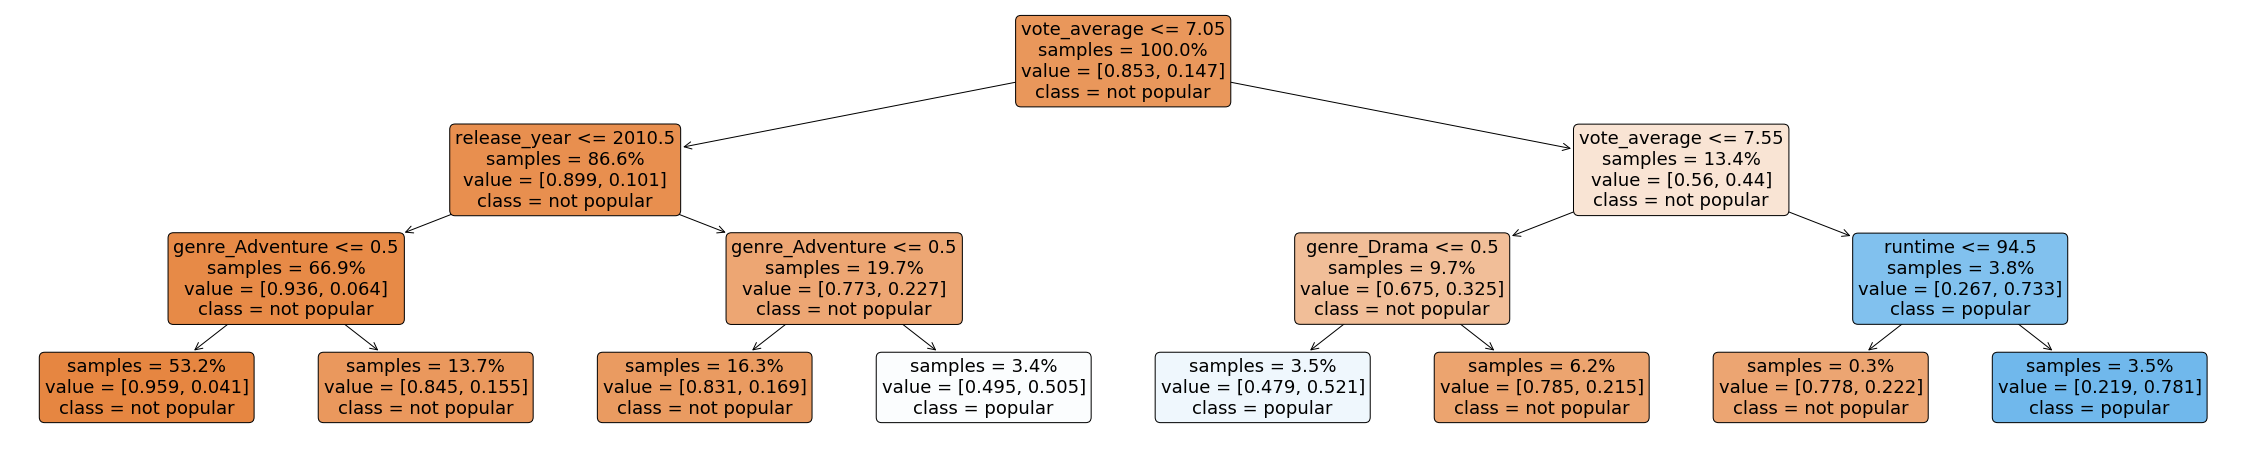

In [31]:
plt.figure(figsize=(40, 8))
a = plot_tree(DT_pop_model, 
              feature_names=list(X_train.columns),  #what the x values are
              class_names=["not popular", "popular"],  #what the y values are
              filled=True, #should the bubbles be colored
              rounded=True, #should the bubbles be rounded
#               label="all", #which boxes should have a label [all, root, none]
              proportion=True, #should it be # samples or % dataset
              impurity=False, #show the entropy?
#               node_ids=False, #show the index of the node
              fontsize=18)
plt.savefig("decision tree popularity.jpg")

If desired, we can get the nodes ourselves using code seen [here](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py):

In [25]:
tree = DT_pop_model.tree_
print("Left child's index for each node:", tree.children_left)
print("Right child's index for each node:", tree.children_right)
print("Deciding feature for each node:", tree.feature, ":", [X_train.columns[feat] for feat in tree.feature])
print("Threshold for decision at each node:", tree.threshold)

Left child's index for each node: [ 1  2  3 -1 -1  6 -1 -1  9 10 -1 -1 13 -1 -1]
Right child's index for each node: [ 8  5  4 -1 -1  7 -1 -1 12 11 -1 -1 14 -1 -1]
Deciding feature for each node: [ 1  2 27 -2 -2 27 -2 -2  1 23 -2 -2  0 -2 -2] : ['vote_average', 'release_year', 'genre_Adventure', 'genre_Foreign', 'genre_Foreign', 'genre_Adventure', 'genre_Foreign', 'genre_Foreign', 'vote_average', 'genre_Drama', 'genre_Foreign', 'genre_Foreign', 'runtime', 'genre_Foreign', 'genre_Foreign']
Threshold for decision at each node: [ 7.04999995e+00  2.01050000e+03  5.00000000e-01 -2.00000000e+00
 -2.00000000e+00  5.00000000e-01 -2.00000000e+00 -2.00000000e+00
  7.54999995e+00  5.00000000e-01 -2.00000000e+00 -2.00000000e+00
  9.45000000e+01 -2.00000000e+00 -2.00000000e+00]


### Profit Model

Same as above, but with profit

In [26]:
# split each node based on the best (best) information gain (entropy)
DT_prof_model = DecisionTreeClassifier(criterion="entropy", splitter="best", max_depth = 3)
DT_prof_model.fit(X_train, Y_train["profitable"])
dt_accuracy = DT_prof_model.score(X_test, Y_test["profitable"])
print("Accuracy:", dt_accuracy)

Accuracy: 0.6155507559395248


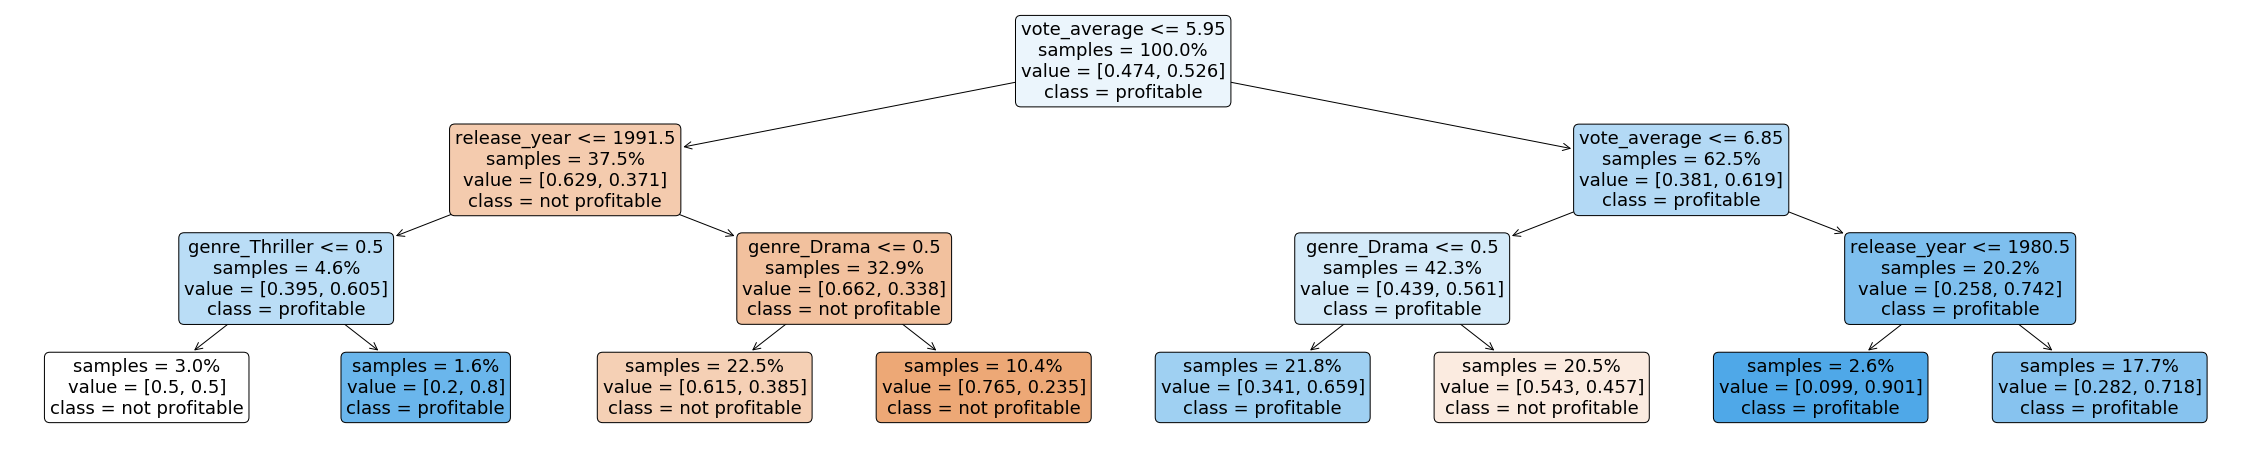

In [30]:
plt.figure(figsize=(40, 8))
a = plot_tree(DT_prof_model, 
              feature_names=list(X_train.columns), 
              class_names=["not profitable", "profitable"], 
              filled=True, 
              rounded=True,
              proportion=True,
              impurity=False,
              fontsize=18)
plt.savefig("decision tree profitability.jpg")

## Results

<!-- Commented out since I got things backwards but don't want to re-type this
With the models created, we can now look at what the most important attributes are.

Interestingly, the popularity model performed much better than the profitability model. I would guess this is due to the numerous issues I encountered with the profit calculations.

Both models strongly consider the vote average as the most important element, which makes sense. Movies that are generally liked should match with whatever our metric for success is.

Both also have the same second rows as well, with the lower votes looking at the release year, and the higher votes once again splitting on the votes. This likely accounts for cult classic movies, as those which aren't ranked as high will take longer to gain popularity. But, these won't be as profitable, as I would the value available from a movie decreases over time.

As for the smaller results, some were surprising and others not so much. Low ranking, new movies were less popular when they were adventure movies. Really high rated movies were more popular when they were shorter (under 94 minutes). Middle-voted movies were all around un-popular and un-profitable unless they were a drama
-->

Vote average was the most important factor for both

More popular:
- Adventure genre
- Not drama genre
- Longer runtime
- Newer release year

More profitable:
- Not drama genre
- Older release year
- Thriller genre